# GMIT HDip Data Analytics; Machine Learning and Statistics; Project  
Read data from a csv file containing two values - speed and power - for the power generated by a wind turbine(s) according to wind speed. 

Create a web application and Python Flask server for the user to get predicted values from the web page (separate from this notebook).  

Let a user input wind speeds, and provide predictions of expected power using a machine learning model.

Start by reading in the csv file [1] and looking at the data:  
[1] Load data from txt with Pandas ; https://stackoverflow.com/questions/21546739/load-data-from-txt-with-pandas

In [13]:
import pandas as pd
import numpy as np
df = pd.read_csv('powerproduction.txt', sep=",")

print(df)
c0 = df.columns[0]
c1 = df.columns[1]

      speed  power
0     0.000    0.0
1     0.125    0.0
2     0.150    0.0
3     0.225    0.0
4     0.275    0.0
..      ...    ...
495  24.775    0.0
496  24.850    0.0
497  24.875    0.0
498  24.950    0.0
499  25.000    0.0

[500 rows x 2 columns]


The first and last few entries all have power 0.0. Check some values from the middle of the data set :

In [14]:
print(df[245:255])

      speed   power
245  12.387  37.159
246  12.412  52.952
247  12.462  44.745
248  12.487  44.735
249  12.538  44.801
250  12.563  42.336
251  12.588  54.079
252  12.613  51.471
253  12.663  44.880
254  12.713  51.149


Plot the data using Seaborn, to get a visual image of it [2] :  
[2] Week 4 notes, Models, Train; GMIT Data Analytics HDip ; Machine Learning and Statistics notes

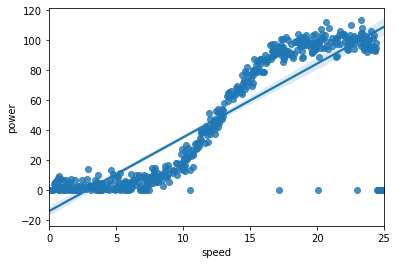

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=c0,y=c1,data=df)
plt.show()

The straight line doesn't provide a great fit to the data. There is a clear 's' shaped appearance displayed in the plot of the data above. Consider the plots of first order (y = x), second order (y = x^2) and third order polynomials (y = x^3) :

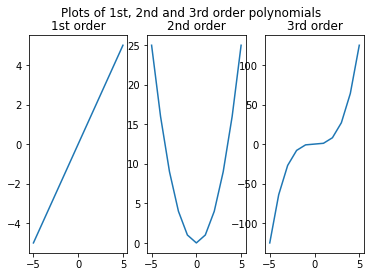

In [16]:
x = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
y1 = [number      for number in x]
y2 = [number ** 2 for number in x] 
y3 = [number ** 3 for number in x]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Plots of 1st, 2nd and 3rd order polynomials')
ax1.plot(x, y1)
ax1.set_title('1st order')
ax2.plot(x, y2)
ax2.set_title('2nd order')
ax3.plot(x, y3)
ax3.set_title('3rd order')
plt.show()

The straight line is the first order, like the regression line in the plot above. The shape of the 3rd order plot best fits the plot of the actual data, so we'll try applying a third order polynomial to get a best fit line [3] :   
[3] Fitting different kinds of models; https://seaborn.pydata.org/tutorial/regression.html

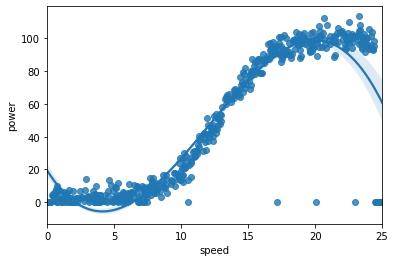

In [5]:
sns.regplot(x=c0,y=c1,data=df, order=3)
plt.show()

This gives a better fit, but there are some power values that don't fit the curve too well at the bottom and top ranges of the speed, and a few in the middle. Lets try a higher order polynomial - 5 -

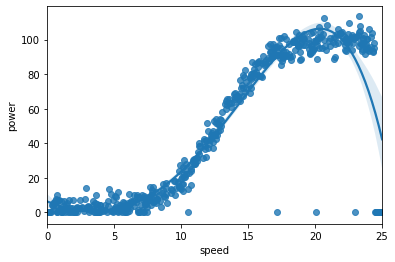

In [18]:
sns.regplot(x=c0,y=c1,data=df, order=5)
plt.show()

This gives a better fit for low speed values, but is still inaccurate for high values. The misfit top and bottom values are due to there being zero power output at wind speeds below a certain minimum value (the cut-in speed) and above a certain maximum value (the cut-out speed). The cut-in speed is due to there being insufficient torque to overcome friction within the turbine mechanism[1]. The cut-out speed prevents damage to the turbine by ensuring maximum structural loads within drive train components are not exceeded [2] The zero values for power mid-range are unexplained, but are probably due to the turbine(s) being turned off deliberately for routine maintenance or repair, or perhaps if power supply is exceeding demand [3]. For someone using the data a separate analysis of the frequency and duration of these mid-range zero power values would probably be appropriate to conduct. When the user runs this code to get predicted power values, two results will be presented - one that includes the mid-term zero values and one that excludes them - we do not know which is most useful. The cut-in and cut-out values will be displayed to the user on the web page, and if they enter wind speeds below or above these respectively the predicted power output will simply be output as 0. 
Plot the data with the zero values removed to see how the regression line looks without them.  
Also display the 'score' for the model - a measure of how well the predicted values match the actual values, with '1'
being a perfect fit. [4]
[1] Power curve ; https://www.sciencedirect.com/topics/engineering/power-  coefficient#:~:text=4.7.,are%20specified%20on%20power%20curves.
[2] https://www.windpowerengineering.com/how-turbulent-wind-abuse-wind-turbine-drivetrains/
[3] https://www.quora.com/In-a-field-of-wind-turbines-why-are-there-a-few-that-do-not-move  
[4] https://stackoverflow.com/questions/24458163/what-are-the-parameters-for-sklearns-score-function

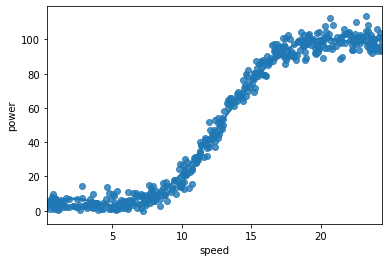

model1 r value -  0.8984832870534454
model2 r value -  0.9879782627661895
model1 prediction for  8  -  [25.11293725]
model2 prediction for  8  -  [7.99091135]


In [20]:
# Polynomial regression ; https://scikit-learn.org/stable/modules/linear_model.html
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import sklearn.linear_model as lin

def f(x,p):
    return p[0] + x*p[1]

def predict(s):
    return f(s,p)

s = df["speed"].to_numpy()
po = df["power"].to_numpy()

i = 0
ix = []
ix2 = []
minP = 0
maxP = 0
for px in po:
    if px == 0:
        ix.append(i)
    else:
        maxP = s[i]
        maxI = i
        if minP == 0:
            minP = s[i]
            minI = i
    i+=1

for i in ix:
    if i < minI or i > maxI:
       ix2.append(i) 
    
s2   = np.delete(s, ix2)
po2  = np.delete(po, ix2)
df2  = df.drop(ix2,axis=0)

s  = np.delete(s, ix)
po = np.delete(po, ix)
df = df.drop(ix,axis=0)

sns.regplot(x=c0,y=c1,data=df, order=5)
plt.show()
        
s = s.reshape(-1,1)
model1 = lin.LinearRegression()
model2 = Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression(fit_intercept=False))])

model1.fit(s,po)
r = model1.score(s,po)
print("model1 r value - ",r)
p = [model1.intercept_ , model1.coef_]

model2.fit(s,po)
r = model2.score(s,po)
print("model2 r value - ",r)

testVal = 8

print("model1 prediction for ",testVal," - ",predict(testVal))

arr = np.array([testVal])
arr = arr.reshape(-1,1)

print("model2 prediction for ",testVal," - ",model2.predict(arr))


This looks like a good fit now with the zero values removed, and we can see that the 'score' (r value) is much closer to 1
for the polynomial of order 5 (model 2) than it is for the straight line fit (model 1) - giving a quantitative confirmation of the predictions better fitting the data. Also, looking at the plot we see the prediction for a wind speed of 8 is clearly much better for model 2 than for model 1.   

Note : In order for the model to be of use to the user, information would be required concerning the data provided, and the data source, depending on the nature of the user.  Many factors may influence the values, for example : 

Is the data from one turbine, or many turbines - what type of turbine is it from; if from many, how many, and of what model types and over what geographical area are they spread.
Where and when were the data gathered - turbulence effects may be more common in some locations, or at certain times of the year than others, and may affect power output, as may altitude which affects air density
Where were the power measurements taken relative to the turbine - locally, or at a distance, and where and how was the wind speed measured. If the power mesurements were not local what are the estimated transmission losses.
What instrumentation was used for the measurements, and when and how was it calibrated  
Might other climatic factors affect the results, such as temperature  
What is the data source, eg an academic study, the turbine manufacturer, an oil industry company - political attitudes may cast into question whether the figures are biased eg perhaps taken from a turbine that is known to have a technical problem or to be a particularly efficient or inefficient model.  
If the user of the data is for example a physicist carrying out research into turbines they may also want to know detailed information about all aspects of particular components of the turbine. It should be made clear who the target audience is for the data, so that the appropriate accompanying information can be provided.


We'll now try using a Neural network machine learning technique for predicting values, and compare the predictions with the sklearn model.  


In [26]:
import tensorflow.keras as kr

#ix = int(len(df.index)*0.7)
#df3 = df.sample(n=ix)

#c0 = df3.columns[0]
#c1 = df3.columns[1]

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)

print(type(train))

s = train["speed"].to_numpy()
po = train["power"].to_numpy()
s = s.reshape(-1,1)
print(s)
print(po)

skmodel = Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression(fit_intercept=False))])
skmodel.fit(s,po)

# Train a neural network model
nnmodel = kr.models.Sequential()
nnmodel.add(kr.layers.Dense(7, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
nnmodel.add(kr.layers.Dense(8, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
nnmodel.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
nnmodel.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

# Fit the data.
nnmodel.fit(train['speed'], train['power'], epochs=700, batch_size=10)

testActual = test.to_numpy()
for i in range(5):
  q = nnmodel.predict( np.array( [testActual[i][0],] ))
  arr = testActual[i][0].reshape(-1,1)
  print("Actual - ",testActual[i][1],"  Predicted (Neural Network)- ",q,"  Predicted (Sklearn Regression)- ",skmodel.predict(arr))

<class 'pandas.core.frame.DataFrame'>
[[20.12 ]
 [10.285]
 [ 3.529]
 [15.315]
 [23.599]
 [13.539]
 [ 1.502]
 [ 7.508]
 [ 3.003]
 [19.169]
 [20.295]
 [23.574]
 [12.162]
 [17.442]
 [18.619]
 [ 2.402]
 [18.769]
 [15.916]
 [15.115]
 [16.992]
 [ 3.954]
 [23.849]
 [24.174]
 [ 7.382]
 [ 2.578]
 [ 7.207]
 [17.492]
 [ 8.308]
 [17.793]
 [13.388]
 [18.318]
 [24.349]
 [ 7.808]
 [21.922]
 [ 5.455]
 [ 4.98 ]
 [ 0.851]
 [ 7.257]
 [14.339]
 [20.045]
 [17.893]
 [12.888]
 [ 3.428]
 [10.26 ]
 [23.624]
 [23.248]
 [ 4.53 ]
 [ 6.481]
 [20.671]
 [ 3.904]
 [10.886]
 [ 2.177]
 [18.794]
 [11.787]
 [11.111]
 [16.617]
 [17.117]
 [16.441]
 [21.471]
 [ 4.304]
 [13.939]
 [23.824]
 [19.069]
 [ 3.028]
 [ 0.826]
 [ 1.401]
 [10.085]
 [ 9.735]
 [ 7.683]
 [ 8.659]
 [ 8.959]
 [19.62 ]
 [ 8.408]
 [ 2.853]
 [ 6.682]
 [20.47 ]
 [ 4.329]
 [ 5.906]
 [19.545]
 [23.549]
 [ 3.378]
 [10.21 ]
 [ 5.956]
 [17.067]
 [22.147]
 [ 0.501]
 [11.662]
 [12.037]
 [12.738]
 [ 9.86 ]
 [17.417]
 [21.046]
 [ 0.626]
 [ 7.057]
 [ 6.757]
 [ 1.101]
 [

32/32 [==============================] - 0s 812us/step - loss: 3587.6738
Epoch 31/700
32/32 [==============================] - 0s 1ms/step - loss: 3567.2388
Epoch 32/700
32/32 [==============================] - 0s 1ms/step - loss: 3547.2944
Epoch 33/700
32/32 [==============================] - 0s 1ms/step - loss: 3527.7537
Epoch 34/700
32/32 [==============================] - 0s 1ms/step - loss: 3508.0686
Epoch 35/700
32/32 [==============================] - 0s 1ms/step - loss: 3488.7810
Epoch 36/700
32/32 [==============================] - 0s 1ms/step - loss: 3469.8521
Epoch 37/700
32/32 [==============================] - 0s 1ms/step - loss: 3450.8591
Epoch 38/700
32/32 [==============================] - 0s 1ms/step - loss: 3431.9785
Epoch 39/700
32/32 [==============================] - 0s 1ms/step - loss: 3413.2925
Epoch 40/700
32/32 [==============================] - 0s 1ms/step - loss: 3394.9587
Epoch 41/700
32/32 [==============================] - 0s 1ms/step - loss: 3376.6138
Epo

32/32 [==============================] - 0s 2ms/step - loss: 1888.8909
Epoch 127/700
32/32 [==============================] - 0s 2ms/step - loss: 1875.0729
Epoch 128/700
32/32 [==============================] - 0s 2ms/step - loss: 1861.6208
Epoch 129/700
32/32 [==============================] - 0s 2ms/step - loss: 1848.1466
Epoch 130/700
32/32 [==============================] - 0s 2ms/step - loss: 1834.7211
Epoch 131/700
32/32 [==============================] - 0s 1ms/step - loss: 1821.2482
Epoch 132/700
32/32 [==============================] - 0s 2ms/step - loss: 1807.9774
Epoch 133/700
32/32 [==============================] - 0s 2ms/step - loss: 1794.3433
Epoch 134/700
32/32 [==============================] - 0s 2ms/step - loss: 1781.2709
Epoch 135/700
32/32 [==============================] - 0s 2ms/step - loss: 1768.1508
Epoch 136/700
32/32 [==============================] - 0s 2ms/step - loss: 1755.1230
Epoch 137/700
32/32 [==============================] - 0s 3ms/step - loss: 1741

32/32 [==============================] - 0s 2ms/step - loss: 870.2982
Epoch 222/700
32/32 [==============================] - 0s 1ms/step - loss: 862.3624
Epoch 223/700
32/32 [==============================] - 0s 875us/step - loss: 854.5204
Epoch 224/700
32/32 [==============================] - 0s 844us/step - loss: 846.7432
Epoch 225/700
32/32 [==============================] - ETA: 0s - loss: 681.187 - 0s 937us/step - loss: 838.5711
Epoch 226/700
32/32 [==============================] - 0s 1ms/step - loss: 830.9304
Epoch 227/700
32/32 [==============================] - 0s 1ms/step - loss: 823.1757
Epoch 228/700
32/32 [==============================] - 0s 1000us/step - loss: 815.2349
Epoch 229/700
32/32 [==============================] - 0s 3ms/step - loss: 807.5513
Epoch 230/700
32/32 [==============================] - 0s 2ms/step - loss: 799.8878
Epoch 231/700
32/32 [==============================] - 0s 2ms/step - loss: 792.2048
Epoch 232/700
32/32 [==============================] - 

32/32 [==============================] - 0s 656us/step - loss: 299.3671
Epoch 317/700
32/32 [==============================] - 0s 1ms/step - loss: 295.3776
Epoch 318/700
32/32 [==============================] - 0s 906us/step - loss: 291.5799
Epoch 319/700
32/32 [==============================] - 0s 750us/step - loss: 287.6451
Epoch 320/700
32/32 [==============================] - 0s 656us/step - loss: 284.0674
Epoch 321/700
32/32 [==============================] - 0s 656us/step - loss: 279.8972
Epoch 322/700
32/32 [==============================] - 0s 656us/step - loss: 276.0500
Epoch 323/700
32/32 [==============================] - 0s 688us/step - loss: 272.2654
Epoch 324/700
32/32 [==============================] - 0s 656us/step - loss: 268.6327
Epoch 325/700
32/32 [==============================] - 0s 687us/step - loss: 264.9737
Epoch 326/700
32/32 [==============================] - 0s 687us/step - loss: 261.3486
Epoch 327/700
32/32 [==============================] - 0s 656us/step -

32/32 [==============================] - 0s 1ms/step - loss: 65.0987
Epoch 413/700
32/32 [==============================] - 0s 2ms/step - loss: 63.9593
Epoch 414/700
32/32 [==============================] - 0s 1ms/step - loss: 62.8545
Epoch 415/700
32/32 [==============================] - 0s 1ms/step - loss: 62.0351
Epoch 416/700
32/32 [==============================] - ETA: 0s - loss: 19.35 - 0s 1ms/step - loss: 60.5461
Epoch 417/700
32/32 [==============================] - 0s 3ms/step - loss: 59.5319
Epoch 418/700
32/32 [==============================] - 0s 1ms/step - loss: 58.4570
Epoch 419/700
32/32 [==============================] - 0s 1ms/step - loss: 57.4340
Epoch 420/700
32/32 [==============================] - 0s 937us/step - loss: 56.4582
Epoch 421/700
32/32 [==============================] - 0s 1ms/step - loss: 55.3547
Epoch 422/700
32/32 [==============================] - 0s 2ms/step - loss: 54.3955
Epoch 423/700
32/32 [==============================] - 0s 2ms/step - loss: 

32/32 [==============================] - 0s 3ms/step - loss: 18.7292
Epoch 510/700
32/32 [==============================] - 0s 2ms/step - loss: 18.3983
Epoch 511/700
32/32 [==============================] - 0s 2ms/step - loss: 18.5870
Epoch 512/700
32/32 [==============================] - 0s 3ms/step - loss: 18.2679
Epoch 513/700
32/32 [==============================] - 0s 3ms/step - loss: 18.1788
Epoch 514/700
32/32 [==============================] - 0s 3ms/step - loss: 18.0949
Epoch 515/700
32/32 [==============================] - 0s 3ms/step - loss: 18.1927
Epoch 516/700
32/32 [==============================] - 0s 3ms/step - loss: 18.3378
Epoch 517/700
32/32 [==============================] - 0s 3ms/step - loss: 18.1811
Epoch 518/700
32/32 [==============================] - 0s 4ms/step - loss: 17.8845
Epoch 519/700
32/32 [==============================] - 0s 3ms/step - loss: 18.0042
Epoch 520/700
32/32 [==============================] - 0s 3ms/step - loss: 18.0284
Epoch 521/700
32/3

32/32 [==============================] - 0s 2ms/step - loss: 16.8040
Epoch 608/700
32/32 [==============================] - 0s 3ms/step - loss: 17.0698
Epoch 609/700
32/32 [==============================] - 0s 2ms/step - loss: 16.7619
Epoch 610/700
32/32 [==============================] - 0s 2ms/step - loss: 16.9175
Epoch 611/700
32/32 [==============================] - 0s 2ms/step - loss: 16.9002
Epoch 612/700
32/32 [==============================] - 0s 3ms/step - loss: 16.8979
Epoch 613/700
32/32 [==============================] - 0s 1ms/step - loss: 16.8351
Epoch 614/700
32/32 [==============================] - 0s 1ms/step - loss: 16.8343
Epoch 615/700
32/32 [==============================] - 0s 1ms/step - loss: 17.0822
Epoch 616/700
32/32 [==============================] - 0s 2ms/step - loss: 16.8599
Epoch 617/700
32/32 [==============================] - 0s 2ms/step - loss: 16.8865
Epoch 618/700
32/32 [==============================] - 0s 3ms/step - loss: 16.9540
Epoch 619/700
32/3

Actual -  98.223   Predicted (Neural Network)-  [[99.557785]]   Predicted (Sklearn Regression)-  [100.72310258]
